In [38]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Read CSV and Filter Head Injuries") \
    .getOrCreate()

df = spark.read.csv("/storage/home/mdl5637/DS340/more_injuries.csv", header=True, inferSchema=True)


head_injuries_df.printSchema()



root
 |-- player_id: string (nullable = true)
 |-- game_id: string (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- season_type: string (nullable = true)
 |-- week.x: integer (nullable = true)
 |-- posteam: string (nullable = true)
 |-- posteam_type: string (nullable = true)
 |-- defteam: string (nullable = true)
 |-- side_of_field: string (nullable = true)
 |-- yardline_100: integer (nullable = true)
 |-- game_date: integer (nullable = true)
 |-- quarter_seconds_remaining: integer (nullable = true)
 |-- half_seconds_remaining: integer (nullable = true)
 |-- game_seconds_remaining: integer (nullable = true)
 |-- game_half: string (nullable = true)
 |-- qtr: string (nullable = true)
 |-- down: string (nullable = true)
 |-- time: double (nullable = true)
 |-- yrdln: string (nullable = true)
 |-- ydstogo: integer (nullable = true)
 |-- desc: string (nullable = true)
 |-- injured_first_name: string (nullable = true)
 |-- injured_last_

In [ ]:
head_injuries

In [40]:
#df to look at position and impact on injury rate
pos_df = head_injuries_df.select("player role", "position", "height", "weight", "injury area")
pos_df.show()

from pyspark.sql.functions import when

pos_df = pos_df.withColumn("head_injury", when(pos_df["injury area"] == "head", 1).otherwise(0))
pos_df.show(100)

+-------------+--------+------+------+-----------+
|  player role|position|height|weight|injury area|
+-------------+--------+------+------+-----------+
|      tackler|      DL|    74|   297|       head|
|pass reciever|      WR|    73|   190|       head|
| pass blocker|      RB|    69|   195|       head|
|  pass rusher|      RB|    69|   195|       head|
|      tackler|      DL|    74|   250|       head|
| ball carrier|      WR|    69|   170|       head|
| ball carrier|      QB|    77|   237|       head|
|  run blocker|      OL|    75|   329|       head|
| pass catcher|      WR|    72|   215|       head|
|pass reciever|      WR|    72|   195|       head|
|      tackler|      TE|    75|   248|       head|
|           AP|      DL|    75|   294|       head|
|      tackler|      DL|    73|   318|       head|
|      tackler|      DB|    73|   210|       head|
|      tackler|      DB|    74|   196|       head|
|      tackler|      DB|    72|   208|       head|
|      tackler|      LB|    74|

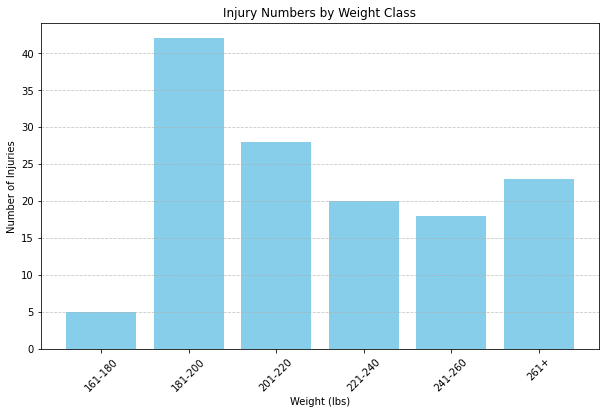

In [20]:
import matplotlib.pyplot as plt

weight_bins = [0, 100, 120, 140, 160, 180, 200, 220, 240, 260, float('inf')]
weight_labels = ['0-100', '101-120', '121-140', '141-160', '161-180', '181-200', '201-220', '221-240', '241-260', '261+']

from pyspark.sql.functions import when
pos_df = pos_df.withColumn("weight_bin", 
                           when((pos_df["weight"] >= 0) & (pos_df["weight"] <= 100), '0-100')
                           .when((pos_df["weight"] > 100) & (pos_df["weight"] <= 120), '101-120')
                           .when((pos_df["weight"] > 120) & (pos_df["weight"] <= 140), '121-140')
                           .when((pos_df["weight"] > 140) & (pos_df["weight"] <= 160), '141-160')
                           .when((pos_df["weight"] > 160) & (pos_df["weight"] <= 180), '161-180')
                           .when((pos_df["weight"] > 180) & (pos_df["weight"] <= 200), '181-200')
                           .when((pos_df["weight"] > 200) & (pos_df["weight"] <= 220), '201-220')
                           .when((pos_df["weight"] > 220) & (pos_df["weight"] <= 240), '221-240')
                           .when((pos_df["weight"] > 240) & (pos_df["weight"] <= 260), '241-260')
                           .otherwise('261+'))

weight_counts = pos_df.groupBy("weight_bin").count().orderBy("weight_bin").collect()

weights = [row["weight_bin"] for row in weight_counts]
injury_numbers = [row["count"] for row in weight_counts]

plt.figure(figsize=(10, 6))
plt.bar(weights, injury_numbers, color='skyblue')
plt.xlabel('Weight (lbs)')
plt.ylabel('Number of Injuries')
plt.title('Injury Numbers by Weight Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


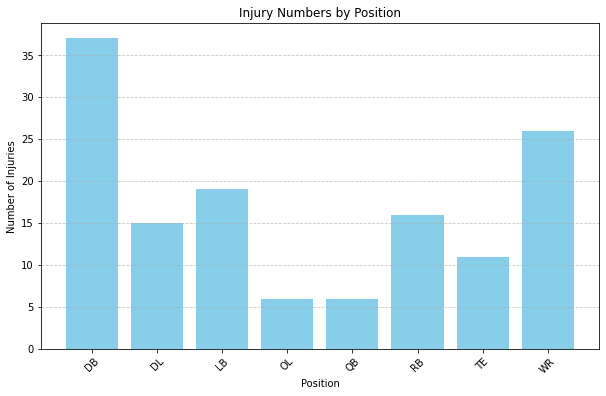

In [21]:
import matplotlib.pyplot as plt

position_counts = pos_df.groupBy("position").count().orderBy("position").collect()

positions = [row["position"] for row in position_counts]
injury_numbers = [row["count"] for row in position_counts]

plt.figure(figsize=(10, 6))
plt.bar(positions, injury_numbers, color='skyblue')
plt.xlabel('Position')
plt.ylabel('Number of Injuries')
plt.title('Injury Numbers by Position')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [24]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

indexer_position = StringIndexer(inputCol="position", outputCol="position_indexed")
indexer_injury = StringIndexer(inputCol="injury area", outputCol="label")
assembler = VectorAssembler(inputCols=["position_indexed", "weight"], outputCol="features")
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[indexer_position, indexer_injury, assembler, dt])
(training_data, test_data) = pos_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(training_data)
predictions = model.transform(test_data)
predictions.select("position", "weight", "injury area", "prediction").show()


+--------+------+-----------+----------+
|position|weight|injury area|prediction|
+--------+------+-----------+----------+
|      DL|   294|       head|       0.0|
|      RB|   195|       head|       0.0|
|      RB|   190|       head|       0.0|
|      TE|   240|       head|       0.0|
|      WR|   190|       head|       0.0|
|      RB|   195|       head|       0.0|
|      WR|   203|       head|       0.0|
|      DB|   218|       head|       0.0|
|      WR|   185|       head|       0.0|
|      WR|   195|       head|       0.0|
|      WR|   180|       head|       0.0|
|      WR|   195|       head|       0.0|
|      WR|   215|       head|       0.0|
|      WR|   183|       head|       0.0|
|      DL|   265|       head|       0.0|
|      WR|   181|       head|       0.0|
|      DB|   190|       head|       0.0|
|      DB|   195|       head|       0.0|
|      DB|   200|       head|       0.0|
|      DL|   297|       head|       0.0|
+--------+------+-----------+----------+
only showing top

In [47]:
from pyspark.ml.feature import StringIndexer

indexer_position = StringIndexer(inputCol="position", outputCol="position_indexed")
pos_df_indexed = indexer_position.fit(pos_df).transform(pos_df)

correlation = pos_df_indexed.stat.corr("position_indexed", "weight")

print("Correlation between position and weight:", correlation)


Correlation between position and weight: 0.6603194331672253


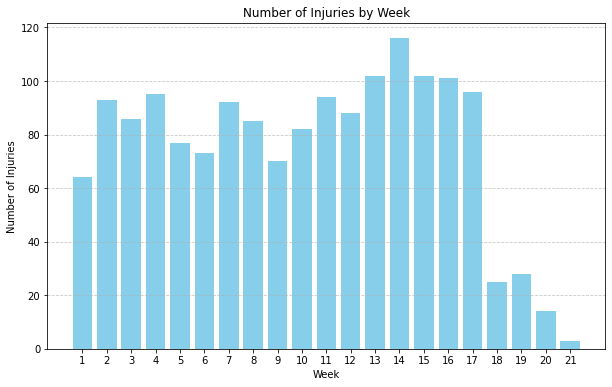

In [55]:
import matplotlib.pyplot as plt

df = df.withColumnRenamed("week.x", "week")

week_game_seconds_df = df.select("week", "game_seconds_remaining")

injuries_by_week = week_game_seconds_df.groupBy("week").count().orderBy("week")

injuries_by_week_df = injuries_by_week.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(injuries_by_week_df["week"], injuries_by_week_df["count"], color='skyblue')
plt.xlabel("Week")
plt.ylabel("Number of Injuries")
plt.title("Number of Injuries by Week")
plt.xticks(injuries_by_week_df["week"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
